# Graph Theory Algorithms with Neo4j and python

## Imports

In [1]:
from py2neo import Graph

In [2]:
from neo4j import GraphDatabase

In [3]:
from tabulate import tabulate

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

In [5]:
%matplotlib inline

## Conect to Neo4j

In [6]:
uri = 'bolt://neo4j-hdx:7687'

In [7]:
driver = GraphDatabase.driver(uri, auth=("neo4j", "test"))

In [11]:
graph = Graph(uri, auth=("neo4j", "test"))

Obtain list of all years with data available:

In [12]:
years_list = [rel for rel in graph.schema.relationship_types if rel.isdigit()]
years_list.sort()

## Centrality

Degree of centrality:
https://neo4j.com/blog/graph-algorithms-neo4j-degree-centrality/

In [136]:
def degree_centrality_given_year(tx,year):
    return tx.run("MATCH (a:CountryYear) "
                  "RETURN a.country as name, "
                  "size((a)-[:RESIDE_IN]->()) AS originates_from, "
                  "size((a)<-[:RESIDE_IN]-()) AS resides_in ".format(year))

Text(0.5, 1.0, 'Resides in')

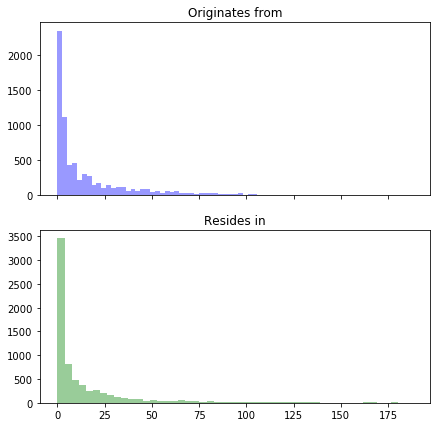

In [158]:
year = 2007

with driver.session() as session:
    centrality_year = session.read_transaction(degree_centrality_given_year, year).data()
    
f, axes = plt.subplots(2, 1, figsize=(7, 7), sharex=True)
sns.distplot([data['originates_from'] for data in centrality_year], kde=False, color="b", ax=axes[0]).set_title("Originates from")
sns.distplot([data['resides_in'] for data in centrality_year], kde=False, color="g", ax=axes[1]).set_title("Resides in")

Include degree of centrality as property in nodes:

In [ ]:
CALL algo.betweenness.stream(
'MATCH (n:CountryYear) WHERE n.year=2009 RETURN id(n) AS id',
'MATCH (n)-[r:RESIDE_IN]->(m) RETURN id(n) AS source, id(m) AS target',
{graph: "cypher"})

YIELD nodeId, centrality

MATCH (CountryYear) WHERE id(CountryYear) = nodeId
RETURN CountryYear.countryearId AS countryyear,centrality
ORDER BY centrality DESC;

In [ ]:
CALL algo.betweenness.stream(
'MATCH (n:CountryYear) WHERE n.year=2009 RETURN id(n) AS id',
'MATCH (n)-[r:RESIDE_IN]->(m) WHERE NOT EXISTS(r.affected_idps) RETURN id(n) AS source, id(m) AS target',
{graph: "cypher"})

YIELD nodeId, centrality

MATCH (n:CountryYear) WHERE id(n) = nodeId
RETURN n.countryearId AS countryyear, centrality
ORDER BY centrality DESC

## Comunity Detection

Include comunity groupping as property in nodes: